In [2]:
library(ggplot2)
library(Seurat)
library(plyr)
library(dplyr)
library(Matrix)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# First pass clustering analysis

Here we will do an initial QC analysis and clustering of the data.

In [3]:
aggr.data <- Read10X("MI_timecourse_CR6_no_norm/filtered_feature_bc_matrix")

genes.seurat <- CreateSeuratObject(aggr.data, min.cells = 10, min.features = 200, project = "Forte")
remove(aggr.data)

genes.seurat[["percent.mt"]] <- PercentageFeatureSet(genes.seurat, pattern = "^mt-")

cellSample <- sub(".*-(.*)","\\1", colnames(genes.seurat))
cellSample <- plyr::mapvalues(cellSample, from = as.character(seq(1,7)),
                             to = c("Healthy", "MI-day 1", "MI-day 3", "MI-day 5", "MI-day 7", 
                                   "MI-day 14", "MI-day 28"))
names(cellSample) = colnames(genes.seurat)
table(cellSample)
genes.seurat <- AddMetaData(genes.seurat, cellSample, col.name = "Condition")

genes.seurat@meta.data$Condition <- factor(genes.seurat@meta.data$Condition, 
                                           levels = c("Healthy", "MI-day 1", "MI-day 3",
                                                      "MI-day 5", "MI-day 7", "MI-day 14", "MI-day 28"))

cellSample
  Healthy  MI-day 1 MI-day 14 MI-day 28  MI-day 3  MI-day 5  MI-day 7 
     8265      5876      8346      7191      6327      8113      8035 

Generate some QC metrics:

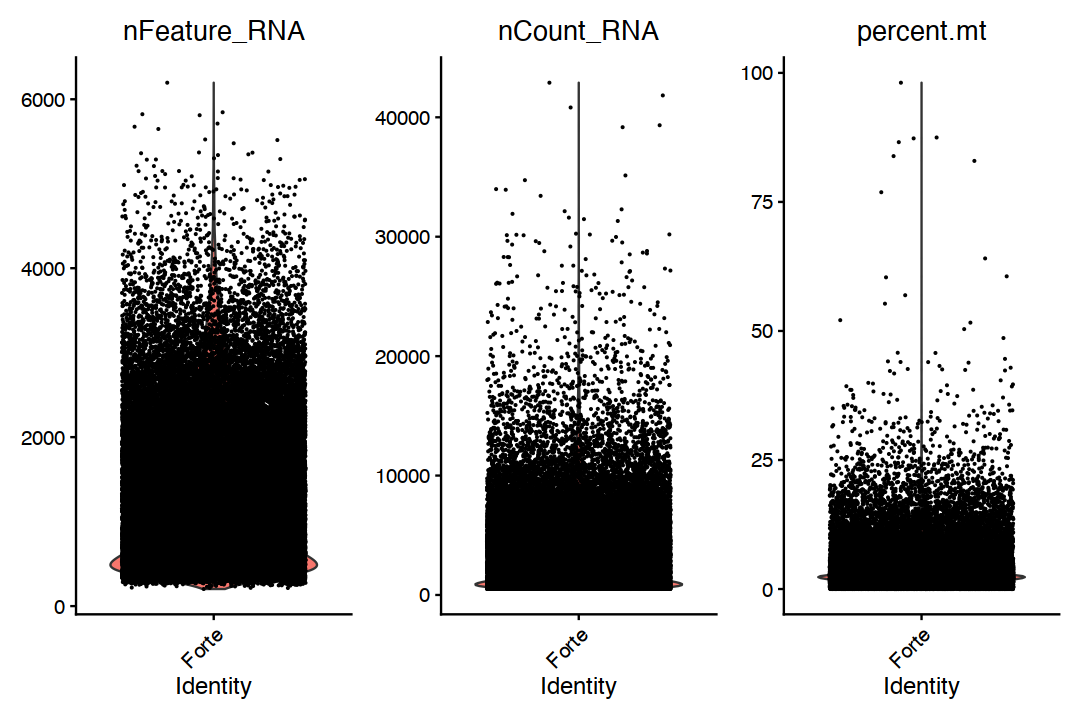

In [4]:
#Violin plot of QC metrics
options(repr.plot.width=9, repr.plot.height=6)
VlnPlot(genes.seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

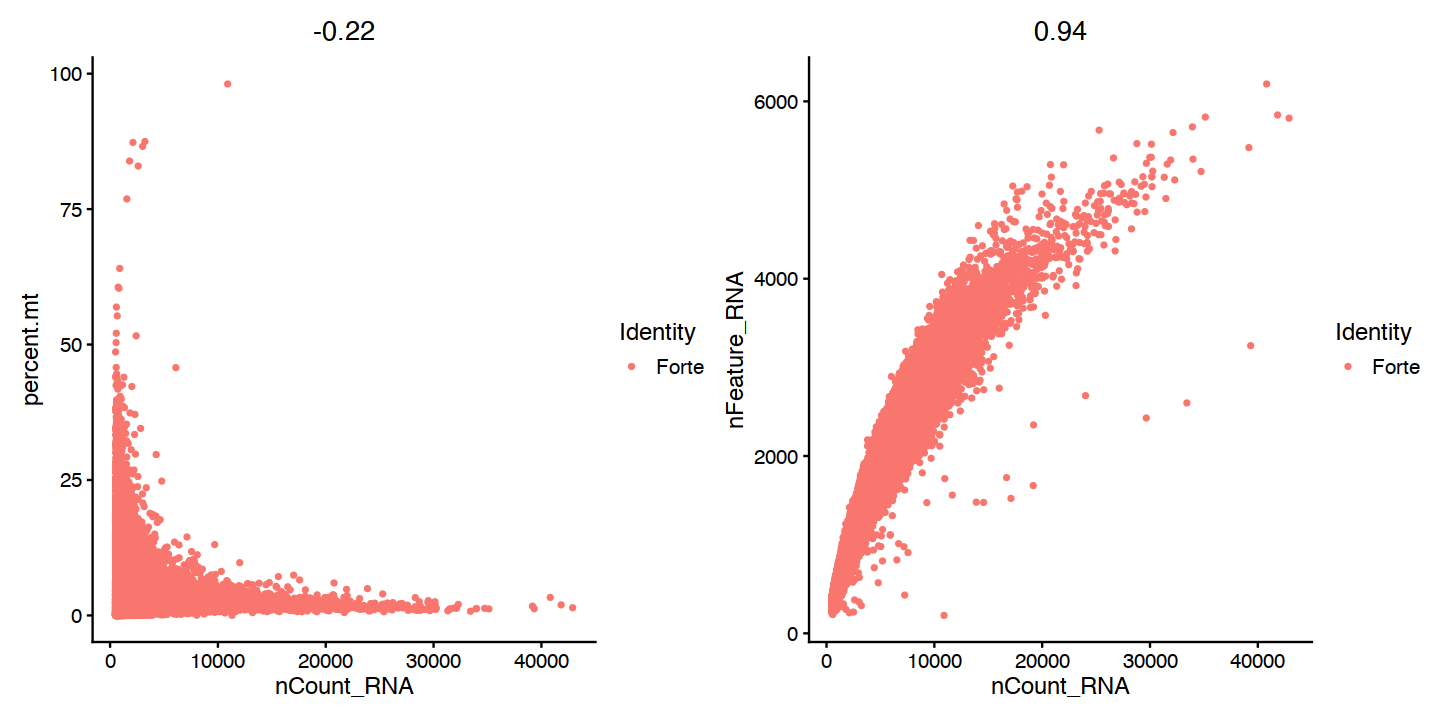

In [5]:
options(repr.plot.width=12, repr.plot.height=6)
plot1 <- FeatureScatter(genes.seurat, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(genes.seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

Filter out some clear outliers, then normalise and run clustering 

In [6]:
genes.seurat <- subset(genes.seurat, subset = nFeature_RNA > 200 & nFeature_RNA < 4000 & percent.mt < 10 &
                         nCount_RNA > 500 & nCount_RNA < 20000)

# Normalise data
genes.seurat <- NormalizeData(object = genes.seurat, 
                              normalization.method = "LogNormalize", 
                              scale.factor = 10000)

# Find higly variable genes
genes.seurat <- FindVariableFeatures(object = genes.seurat, mean.function = "vst", nfeatures = 3000)

# Regress of unwanted variation
genes.seurat <- ScaleData(genes.seurat,  verbose = TRUE)

genes.seurat <- RunPCA(object = genes.seurat, features = VariableFeatures(object = genes.seurat), npcs=25)

## Clustering
genes.seurat <- FindNeighbors(genes.seurat, dims = 1:25)
genes.seurat <- FindClusters(genes.seurat, resolution = 0.8)

### UMAP/t-SNE analysis
genes.seurat <- RunUMAP(genes.seurat, dims = 1:25)

Idents(genes.seurat) <- genes.seurat@meta.data$RNA_snn_res.0.8

Centering and scaling data matrix

PC_ 1 
Positive:  Fcer1g, Tyrobp, Cd52, Ctss, Alox5ap, Cd53, Lyz2, Tmsb4x, Laptm5, Coro1a 
	   Wfdc17, Lgals3, Srgn, Fcgr3, Ctsc, Cotl1, Spi1, Ms4a6c, Lcp1, Cd68 
	   Lst1, Ccl6, Cd14, C5ar1, Rac2, Cyba, Ucp2, Ms4a6d, Tpd52, Lilrb4a 
Negative:  Igfbp7, Dcn, Sparc, Bgn, Serpinh1, Fstl1, Lum, Col1a2, Ccdc80, Serping1 
	   Lhfp, Pcolce, Col3a1, Cygb, Mgp, Mfap5, Dpt, Loxl1, Col1a1, Htra3 
	   Col6a1, Gsn, Serpinf1, Mmp2, Gpx3, Rbp1, Cd34, Ltbp4, Sdc2, Fbln2 
PC_ 2 
Positive:  Fabp4, Egfl7, Gpihbp1, Cav1, Cdh5, Cd36, Esam, Cavin2, Tcf15, Ly6c1 
	   Emcn, Pecam1, Tspan13, Kdr, Mgll, Cd300lg, C1qtnf9, Icam2, Cav2, Slc9a3r2 
	   Myct1, Flt1, Ushbp1, Cldn5, Aqp1, Ecscr, Gimap6, Adgrl4, Tspan7, Gng11 
Negative:  Lgals1, S100a6, Ftl1, Ifi27l2a, Fth1, Col1a2, Col1a1, Mt1, Col3a1, Loxl1 
	   Bgn, Ctsb, Itgb5, Anxa1, Mfap5, Serpinf1, Lum, Cstb, Olfml3, Ecm1 
	   Dpt, Fstl1, Ctsd, Gpx3, Col6a1, Nupr1, Lhfp, Tgfbi, Pcolce, Rcn3 
PC_ 3 
Positive:  Ctsb, Prdx1, Grn, L

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 48380
Number of edges: 1615518

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9003
Number of communities: 31
Elapsed time: 16 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
09:21:14 UMAP embedding parameters a = 0.9922 b = 1.112

09:21:14 Read 48380 rows and found 25 numeric columns

09:21:14 Using Annoy for neighbor search, n_neighbors = 30

09:21:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:21:21 Writing NN index file to temp file /var/folders/2p/fzztw4ls58lcjyzm918ky5900000gn/T//Rtmpou0z5d/file4dad5068c3e4

09:21:21 Searching Annoy index using 1 thread, search_k = 3000

09:21:41 Annoy recall = 100%

09:21:42 Commencing smooth kNN distance calibra

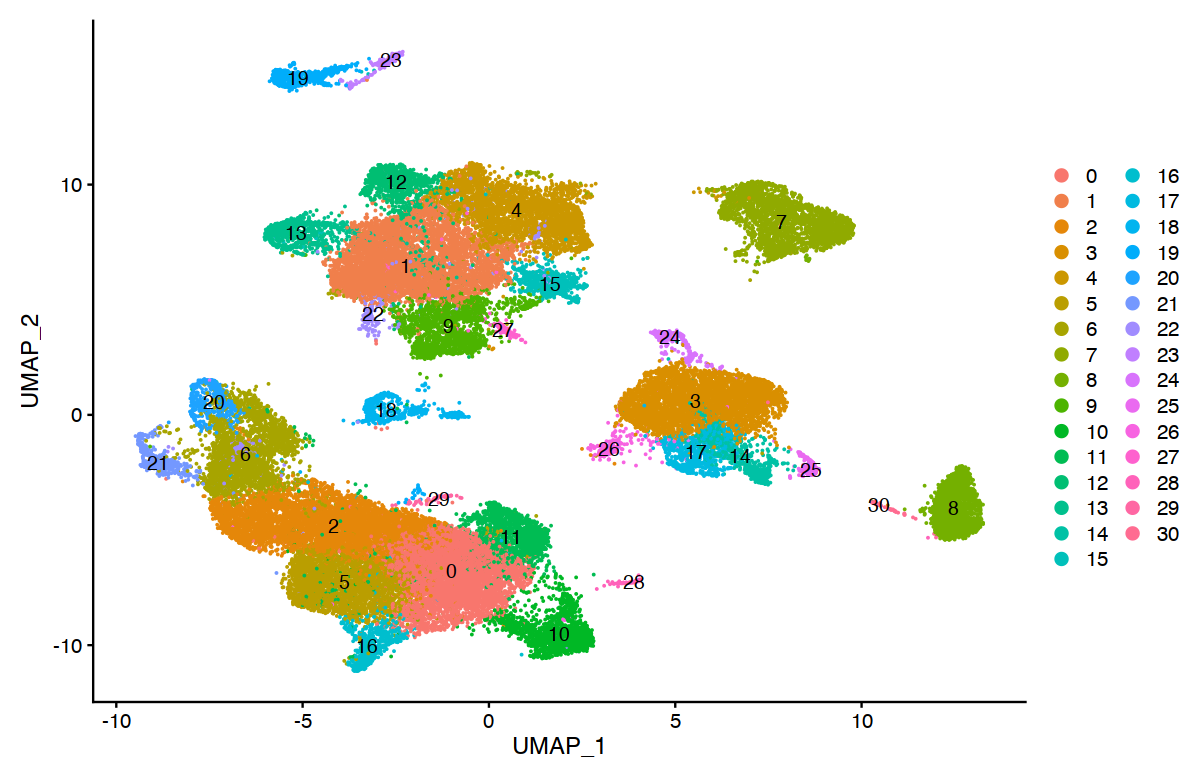

In [7]:
options(repr.plot.width=10, repr.plot.height=6.5)
DimPlot(genes.seurat, reduction = "umap", label = TRUE)

# Doublet filtering

Visualise and filter doublets identified with Scrublet

[1] "Predicted singlets from Scrublet: 51294"
[1] "Overlap with filtered data: 47436"


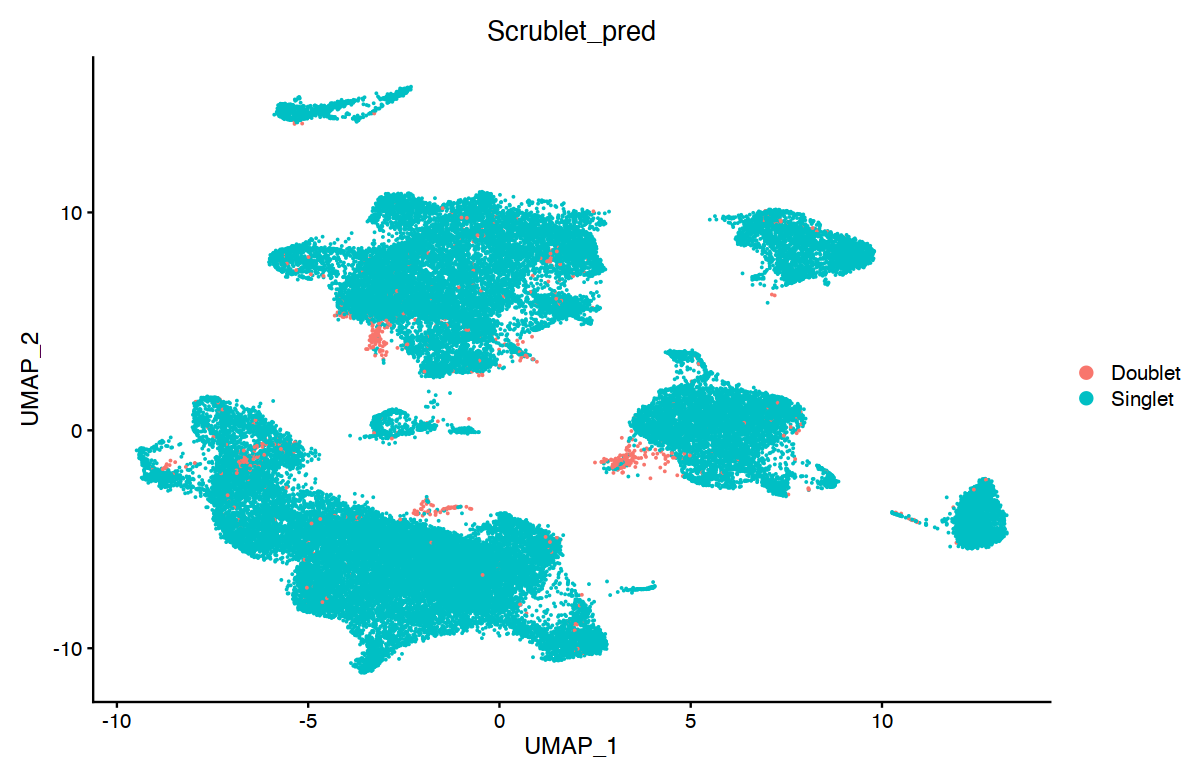

In [8]:
# Visualise the doublets of the UMAP plot
singlet.files <- c("Scrublet_preds/Healthy_singlets.txt",
                   "Scrublet_preds/MI_day1_singlets.txt",
                   "Scrublet_preds/MI_day3_singlets.txt",
                   "Scrublet_preds/MI_day5_singlets.txt",
                   "Scrublet_preds/MI_day7_singlets.txt",
                   "Scrublet_preds/MI_day14_singlets.txt",
                   "Scrublet_preds/MI_day28_singlets.txt")

all.singlets <- c()
for (this.file in singlet.files) {
  singlets <- readLines(this.file)
  all.singlets <- append(all.singlets, singlets)
}
print(paste("Predicted singlets from Scrublet:", length(all.singlets)))
print(paste("Overlap with filtered data:", length(intersect(colnames(genes.seurat), all.singlets))))

scrublet.doublet <- ifelse(colnames(genes.seurat) %in% all.singlets, "Singlet", "Doublet")
genes.seurat@meta.data$Scrublet_pred <- scrublet.doublet

options(repr.plot.width=10, repr.plot.height=6.5)
DimPlot(genes.seurat, group.by = "Scrublet_pred")


In [9]:
# Filter the Seurat object for the singlets
genes.seurat <- subset(genes.seurat, Scrublet_pred == "Singlet")
dim(genes.seurat)

# Normalise data
genes.seurat <- NormalizeData(object = genes.seurat, 
                              normalization.method = "LogNormalize", 
                              scale.factor = 10000)

# Find higly variable genes
genes.seurat <- FindVariableFeatures(object = genes.seurat, mean.function = "vst", nfeatures = 3000)

# Regress of unwanted variation
genes.seurat <- ScaleData(genes.seurat, 
                          vars.to.regress = c("nCount_RNA"), 
                          model.use = "negbinom", 
                          verbose = TRUE)

genes.seurat <- RunPCA(object = genes.seurat, features = VariableFeatures(object = genes.seurat), npcs=60)

## Clustering
genes.seurat <- FindNeighbors(genes.seurat, k.param = 20, dims = 1:30)
genes.seurat <- FindClusters(genes.seurat, resolution = c(0.8, 0.9, 1))

 ### UMAP/t-SNE analysis
genes.seurat <- RunUMAP(genes.seurat, 
                        n.neighbors = 20, 
                        dims = 1:30,
                        min.dist = 0.25)

[1] 18050 47436

Regressing out nCount_RNA

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in glm.nb(formula = fmla, data = regression.mat):
“alternation limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“step size truncated due to divergence”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message:
“glm.fit: algorithm did not converge”
glm.nb failed for gene Igkc; falling back to scale(log(y+1))

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did no

Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 47436
Number of edges: 1611704

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9042
Number of communities: 28
Elapsed time: 15 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 47436
Number of edges: 1611704

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8992
Number of communities: 30
Elapsed time: 14 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 47436
Number of edges: 1611704

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8946
Number of communities: 31
Elapsed time: 13 seconds


11:36:09 UMAP embedding parameters a = 1.121 b = 1.057

11:36:09 Read 47436 rows and found 30 numeric columns

11:36:09 Using Annoy for neighbor search, n_neighbors = 20

11:36:09 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:36:15 Writing NN index file to temp file /var/folders/2p/fzztw4ls58lcjyzm918ky5900000gn/T//Rtmpou0z5d/file4dadb5c4056

11:36:16 Searching Annoy index using 1 thread, search_k = 2000

11:36:30 Annoy recall = 100%

11:36:31 Commencing smooth kNN distance calibration using 1 thread

11:36:33 Initializing from normalized Laplacian + noise

11:36:37 Commencing optimization for 200 epochs, with 1342230 positive edges

11:37:04 Optimization finished



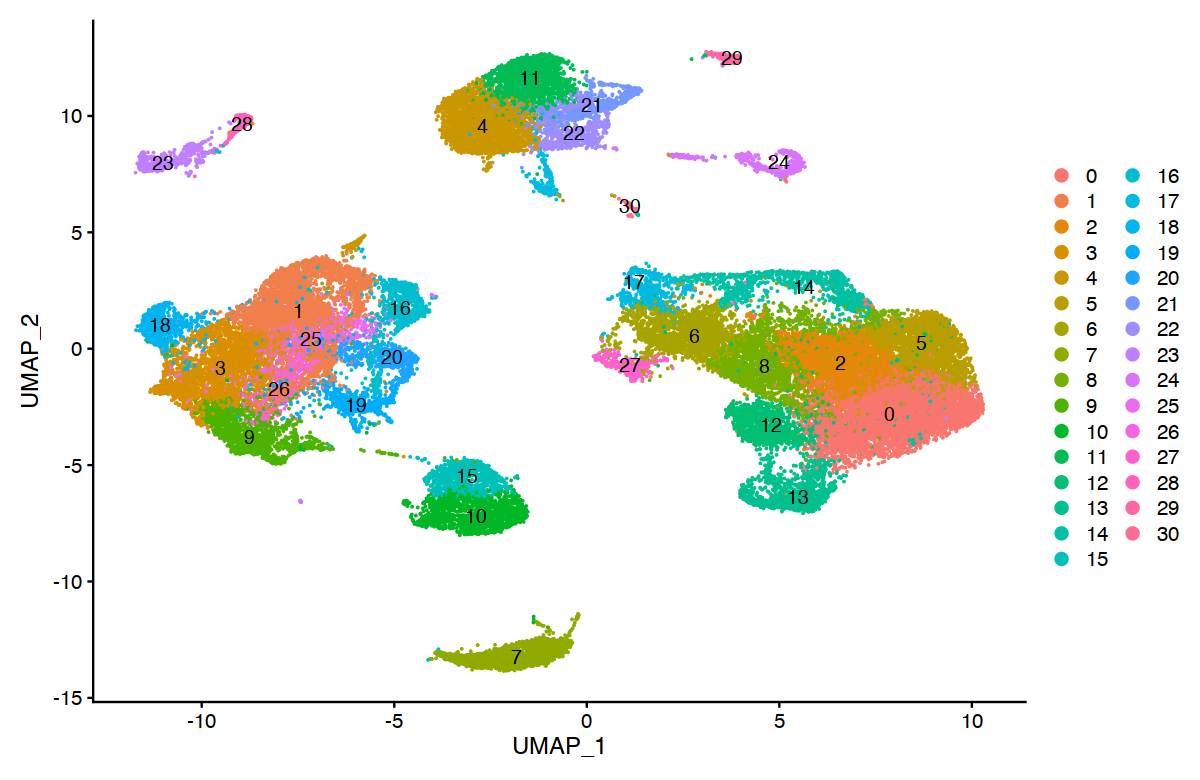

In [10]:
Idents(genes.seurat) <- genes.seurat@meta.data$RNA_snn_res.1

DimPlot(genes.seurat, reduction = "umap", label = TRUE)


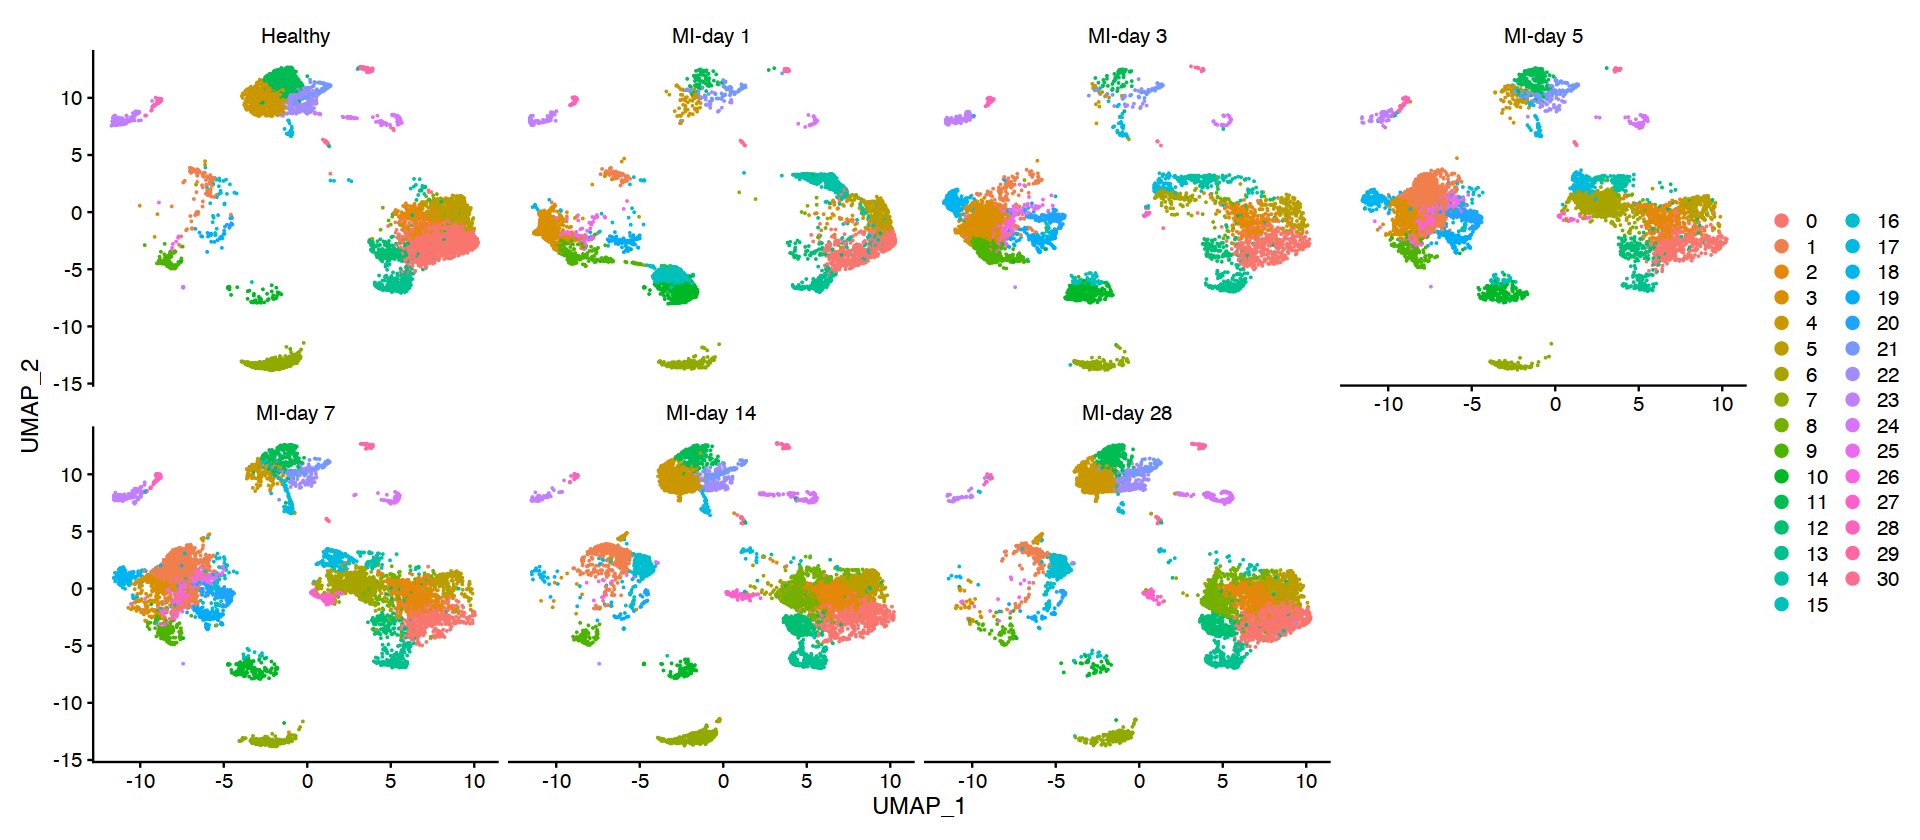

In [11]:
options(repr.plot.width=16, repr.plot.height=7)
DimPlot(genes.seurat, reduction = "umap", split.by = "Condition", ncol=4)

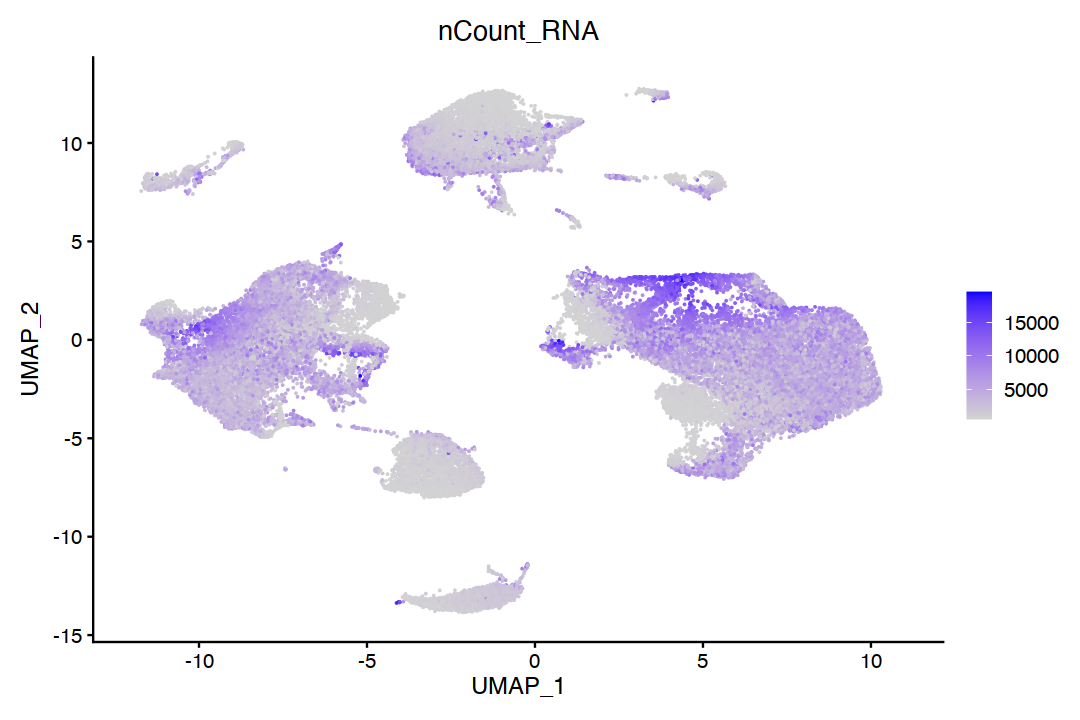

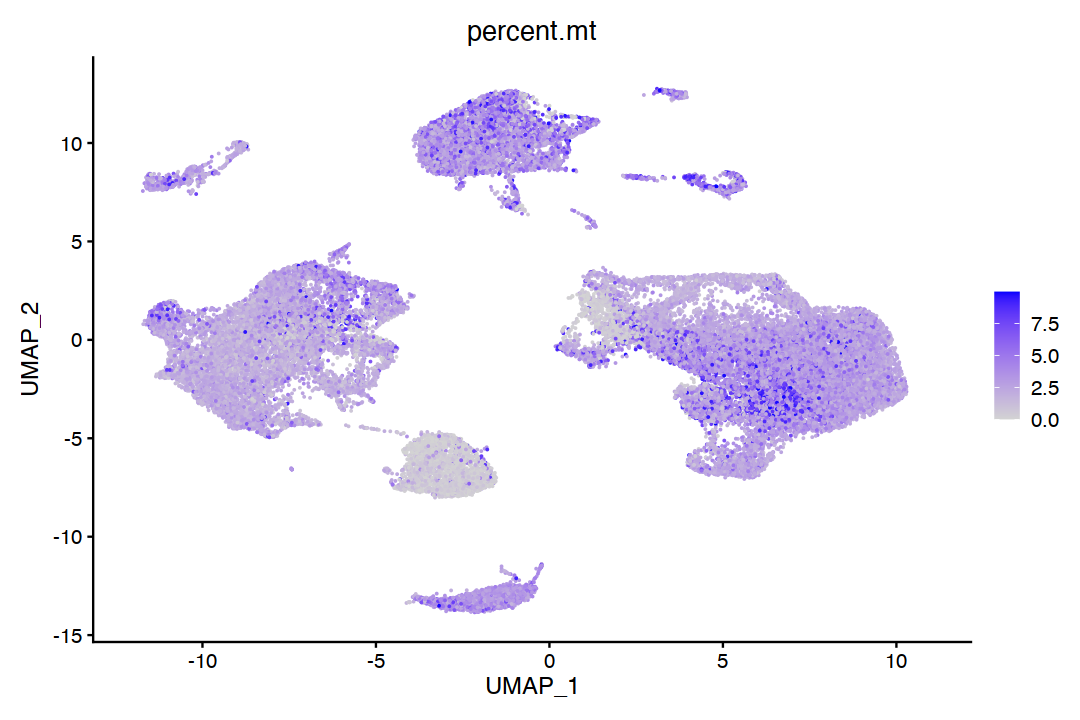

In [12]:
options(repr.plot.width=9, repr.plot.height=6)
FeaturePlot(genes.seurat, "nCount_RNA")
FeaturePlot(genes.seurat, "percent.mt")

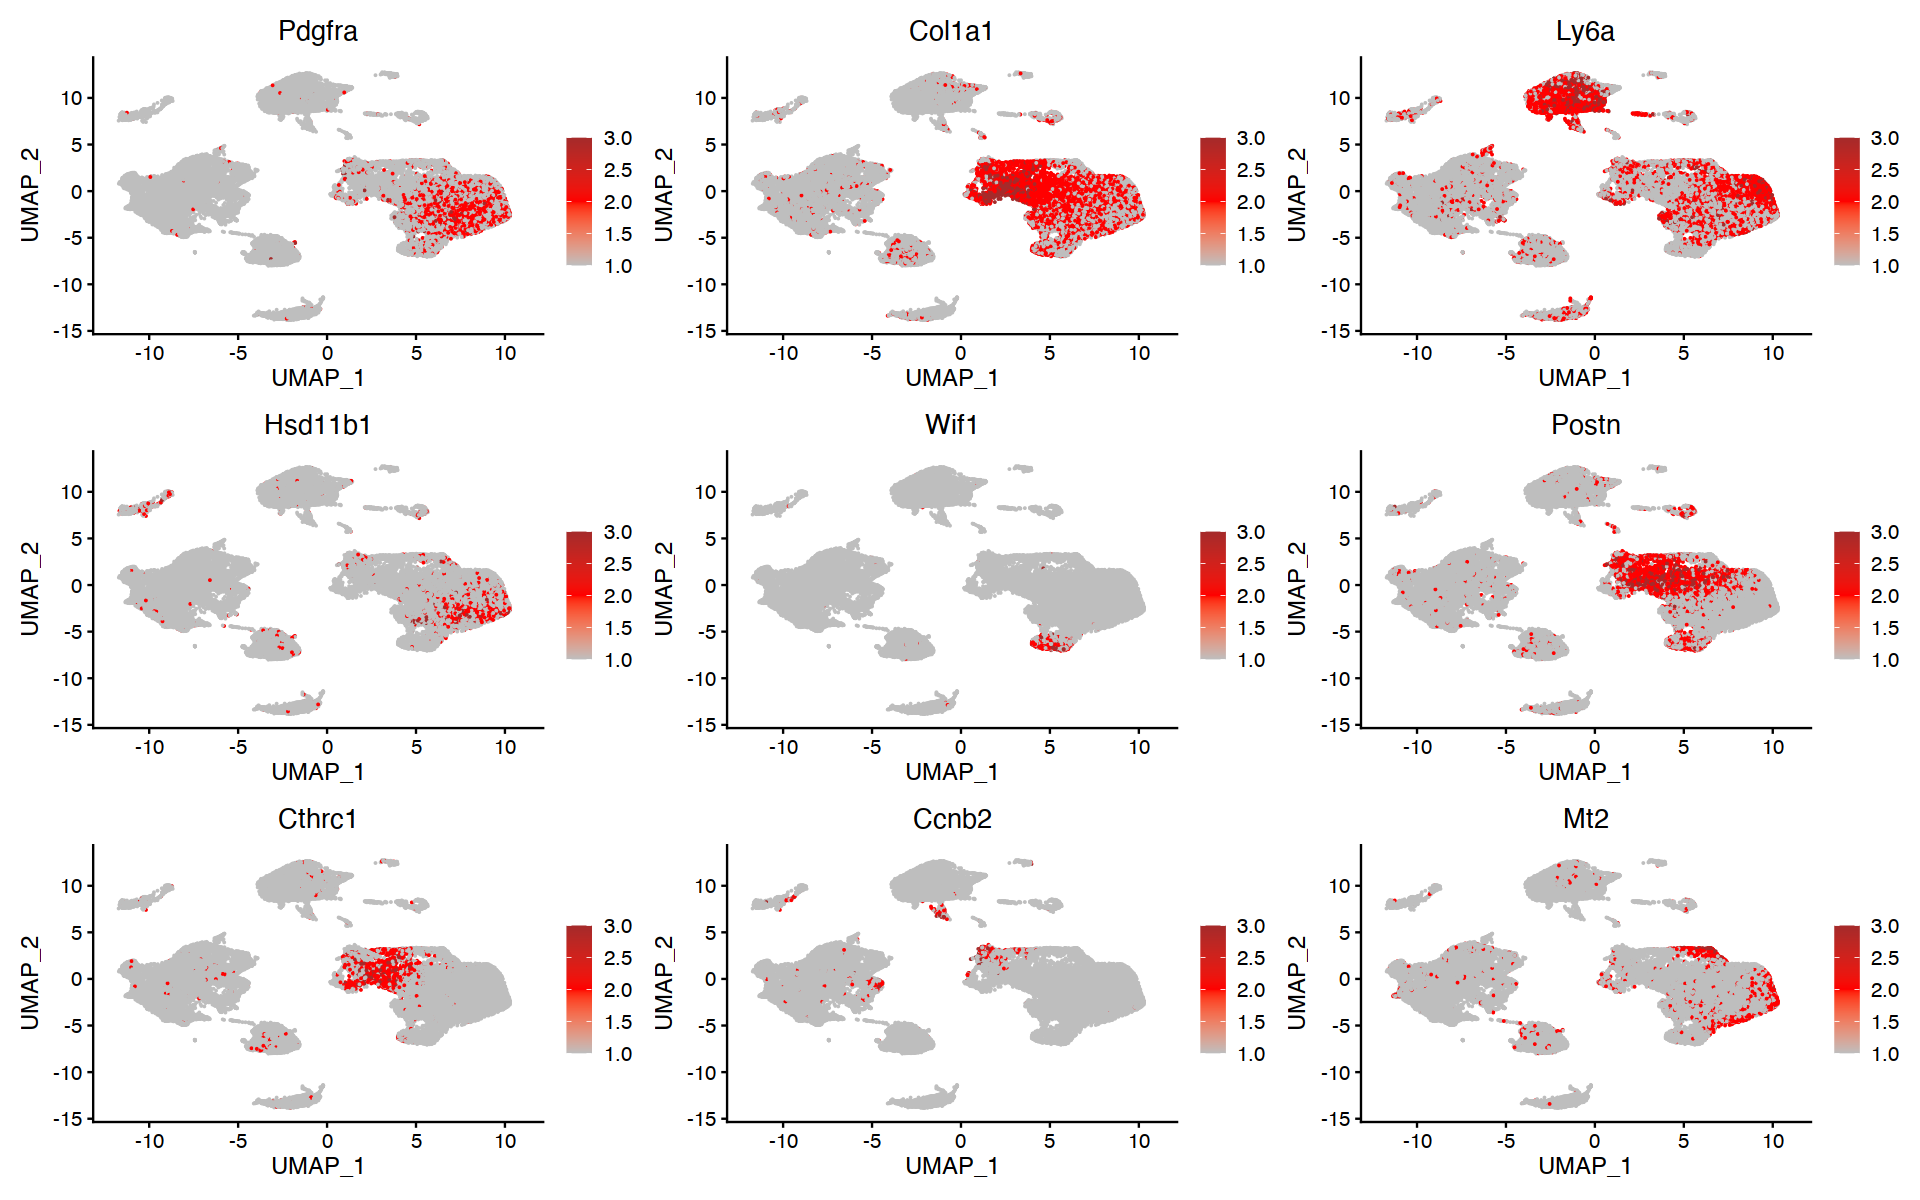

In [13]:
options(repr.plot.width=16, repr.plot.height=10)
FeaturePlot(genes.seurat, c("Pdgfra", "Col1a1", "Ly6a", "Hsd11b1", "Wif1", "Postn", "Cthrc1", "Ccnb2", "Mt2"), 
            cols = c("grey", "red", "brown"))

In [19]:
# Cluster 12 doesn't obviously correspond to an expected fibroblast type
# Calculate DEGs comparing to the remaining fibroblasts
marker.table <- FindMarkers(genes.seurat, ident.1 = "12", ident.2 = c("0", "2", "5", "6", "8", "13", "14", "17"),
                           only.pos = TRUE, logfc.threshold = 1)
marker.table <- subset(marker.table, p_val_adj < 0.05)
head(marker.table, n = 12)

p_val avg_log2FC pct.1 pct.2 p_val_adj
Xist 0     1.894078   0.146 0.005 0

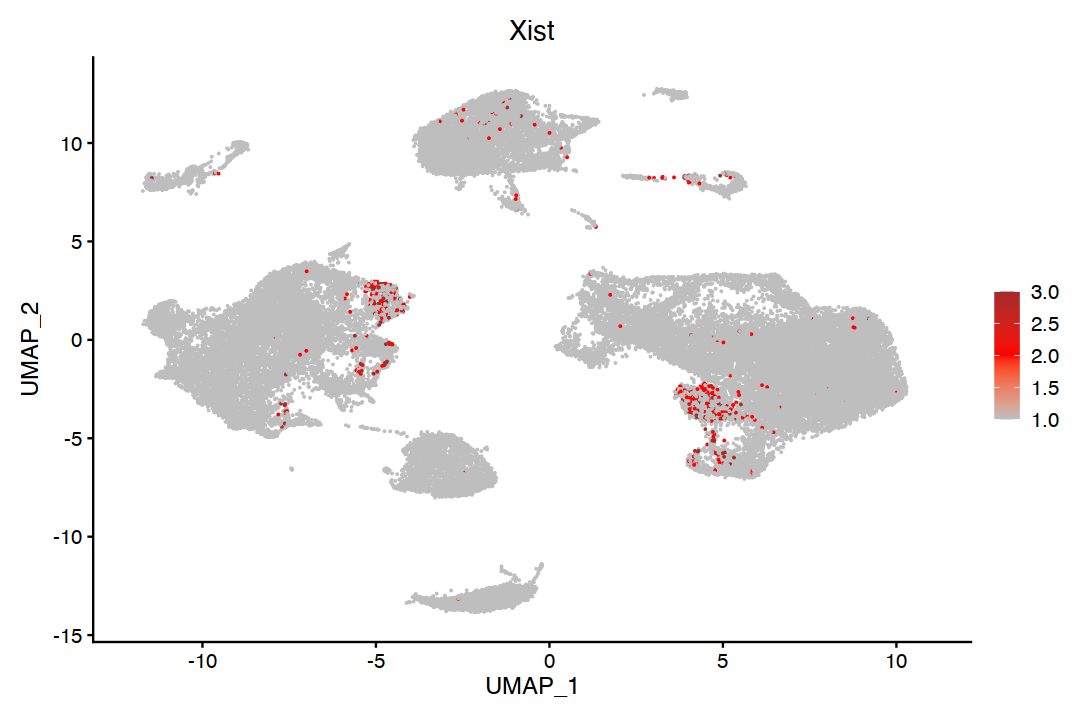

In [15]:
# Only significant marker gene in cluster 12 is Xist

options(repr.plot.width=9, repr.plot.height=6)
FeaturePlot(genes.seurat, "Xist", cols = c("grey", "red", "brown"))

# Select fibroblasts

Will select out the high confidence fibroblast clusters (excluding 12).

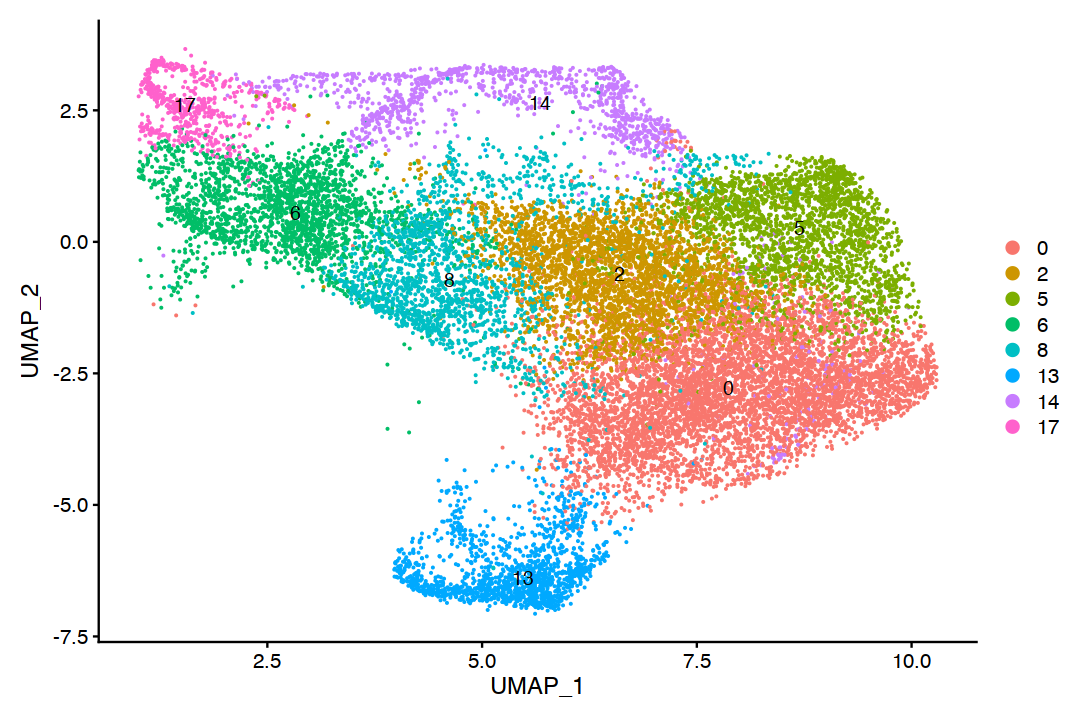

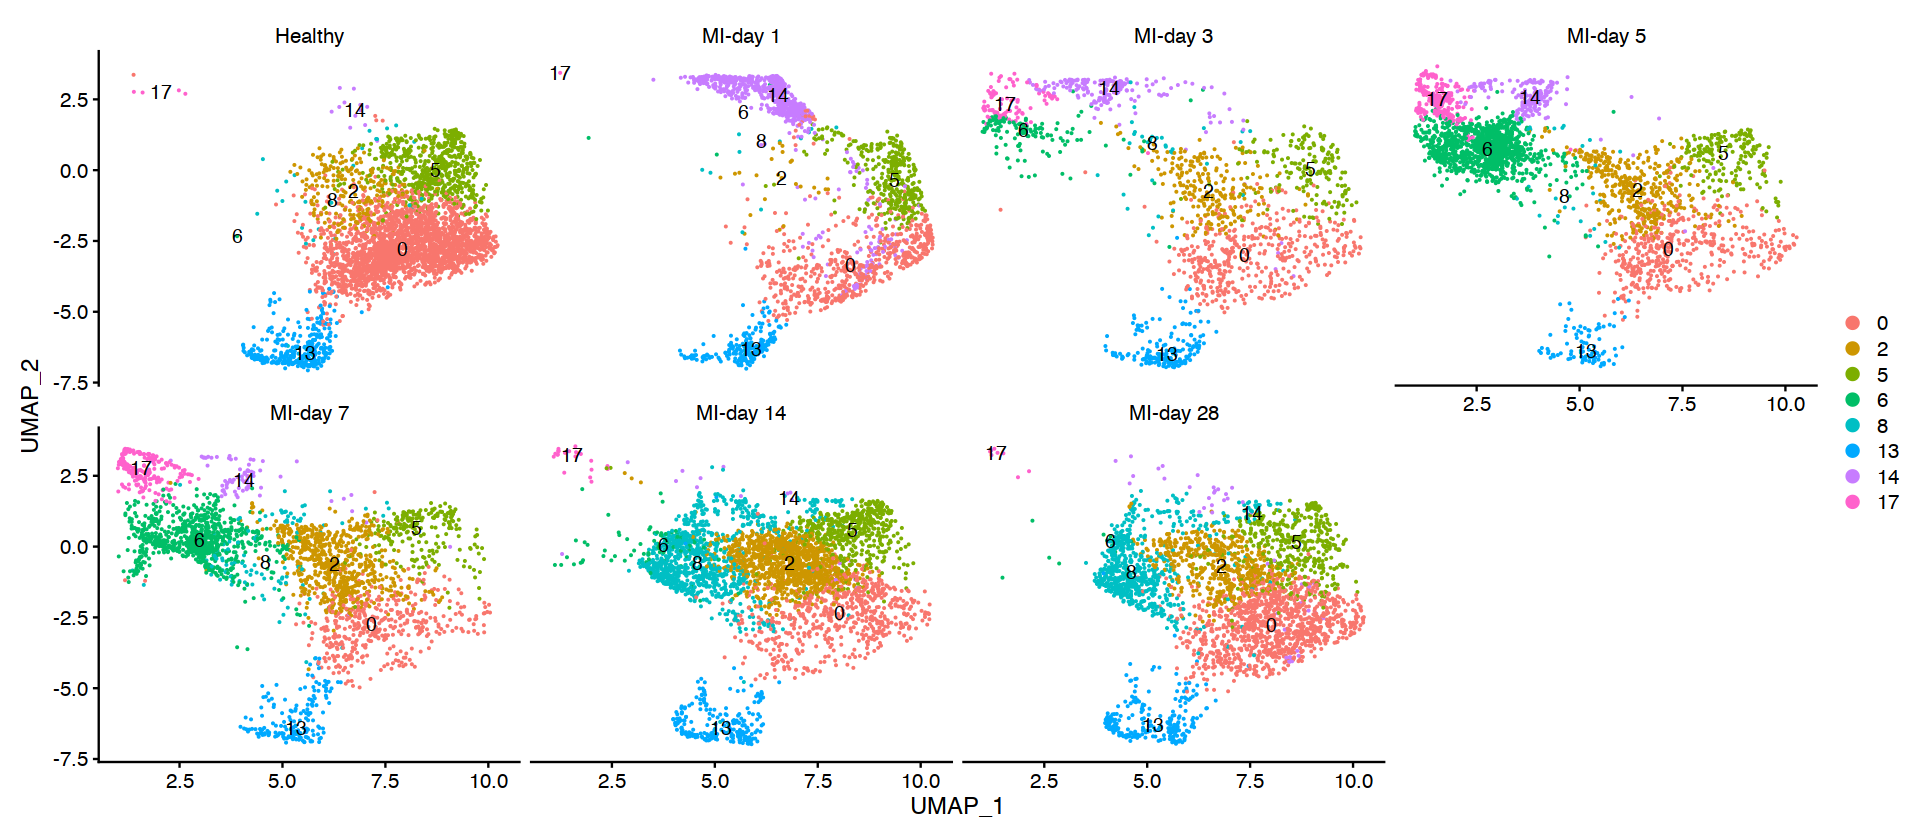

In [16]:
fibro.clusters <- c("0", "2", "5", "6", "8", "13", "14", "17")

fibroblasts.seurat <- subset(genes.seurat, idents = fibro.clusters)

fibroblasts.seurat <- subset(fibroblasts.seurat, UMAP_1 > 1)
fibroblasts.seurat <- subset(fibroblasts.seurat, UMAP_2 < 5 & UMAP_2 > -10)

options(repr.plot.width=9, repr.plot.height=6)
DimPlot(fibroblasts.seurat, label = TRUE)
options(repr.plot.width=16, repr.plot.height=7)
DimPlot(fibroblasts.seurat, label = TRUE, split.by = "Condition", ncol = 4)

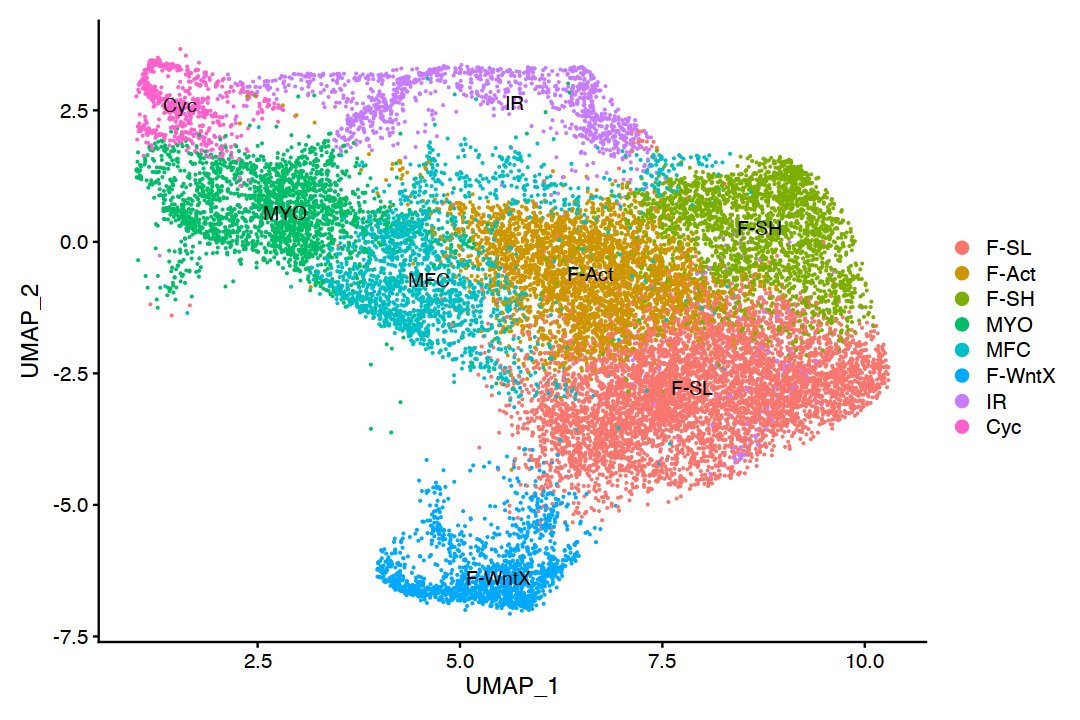

In [17]:
## Update the population names
popln.names <- c("F-SL", "F-Act", "F-SH", "MYO", "MFC", "F-WntX", "IR", "Cyc")
Idents(fibroblasts.seurat) <- plyr::mapvalues(Idents(fibroblasts.seurat),
                                              from = fibro.clusters,
                                              to = popln.names)

fibroblasts.seurat$TIP_cellnames <- Idents(fibroblasts.seurat)

options(repr.plot.width=9, repr.plot.height=6)
DimPlot(fibroblasts.seurat, reduction = 'umap', label = TRUE)

# Session information

In [20]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRlapack.dylib

locale:
[1] en_AU.UTF-8/en_AU.UTF-8/en_AU.UTF-8/C/en_AU.UTF-8/en_AU.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] Matrix_1.3-4       dplyr_1.0.7        plyr_1.8.6         SeuratObject_4.0.2
[5] Seurat_4.0.3       ggplot2_3.3.5     

loaded via a namespace (and not attached):
  [1] nlme_3.1-152          spatstat.sparse_2.0-0 matrixStats_0.60.0   
  [4] RcppAnnoy_0.0.19      RColorBrewer_1.1-2    httr_1.4.2           
  [7] repr_1.1.3            sctransform_0.3.2     tools_4.1.0          
 [10] utf8_1.2.2            R6_2.5.0              irlba_2.3.3          
 [13] rpart_4.1-15          KernSmooth_2.23-20 